# Python API to www.argovis.com

This post is the first part of a three-part series into argovis.
1. [Argovis api](http://www.itsonlyamodel.us/argovis-python-api.html) introduces my website [www.argovis.com](http://www.argovis.com), and how users can access data using a python API. 
2. [Linear time series analysis in R](http://www.argo.ucsd.edu/r-time-series-fit.html) shows how time series models can be used to fit ocean temperatures from Argo data.
3. [Linear time series model fitting in python](http://www.argo.ucsd.edu/python-time-series-fit.html) gives further detail on how non-linear least squares fitting is typically done on time series. 

For over a decade, the [ARGO](http://www.argo.ucsd.edu/index.html) program has provided temperature, salinity and pressure data (T/S/P) on a global scale for depths as far as 2000 dbar, with unprecedented spatial and temporal resolution and no seasonal bias. Close to two million profiles have been collected and made publicly available on Argo’s Global Data Assembly Centres (GDACs) on FTP servers. Unfortunately, online tools for selection and visualization of this big data set are limited slow to access.

In response, a webapp [www.argovis.com](http://www.argovis.com) attempts to improve data access. Overall, this website offers seamless navigation of the Argo dataset. Argo now has a maintainable, scalable, and portable tool written with representational state transfer (REST) architecture. RESTful design offers us the opportunity to feature cloud computing applications; chiefly, map comparison from existing gridded Argo products, as well as parameter estimation such as basin mean T/S/P.

The following code is an interface to argovis.com. HTTP 'get' requests access the web app's database, similar to a browser; however, there is no HTML or javascript. Essentially, this interface is used to query the same database that builds the website. The idea behind this approach is that we no longer rely on the browser to handle queries.

This script will guide a python user to:

[1. Query a specific profile its id, designated by its platform (WMO) number with its cycle number, connected by an underscore. For example '3900737_9'](#section_one)

[2. Query a specified platform by number. Example '3900737'.](#section_two)

[3.1 Query profiles within a given shape, date range, and pressure range.](#section_three)

[3.2 Query profiles position, date, and cycle number within month and year.](#section_three_two)

[4. Plot query results](#section_four)

[5. Create time series given for a selection and set of dates.](#section_five)

[6. Query database using a gridded scheme](#section_six)

[7. Plot gridded data using Cartopy and Basemap Libraries](#section_seven)

Firstly, following libraries are called

In [1]:
import requests
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode()
import cmocean
import matplotlib.pylab as plt
from scipy.interpolate import griddata
from datetime import datetime
import pdb
import os

# depreciated but still usefull.
from mpl_toolkits.basemap import Basemap

#used for map projections
from netCDF4 import Dataset as netcdf_dataset
from cartopy import config
import cartopy.crs as ccrs

%matplotlib inline

#sets plot styles
import seaborn as sns
from matplotlib import rc
from matplotlib import rcParams
import matplotlib.ticker as mtick
rc('text', usetex=False)
rcStyle = {"font.size": 10,
           "axes.titlesize": 20,
           "axes.labelsize": 20,
           'xtick.labelsize': 16,
           'ytick.labelsize': 16}
sns.set_context("paper", rc=rcStyle)
sns.set_style("whitegrid", {'axes.grid' : False})
myColors = ["windows blue", "amber", "dusty rose", "prussian blue", "faded green", "dusty purple", "gold", "dark pink", "green", "red", "brown"]
colorsBW = ["black", "grey"]
sns.set_palette(sns.xkcd_palette(myColors))

curDir = os.getcwd()
docDir = os.path.join(curDir, 'docs')

<a name="section_one"/> </a>
# 1. Get A Profile

The requests library handles HTTP get requests. If the message is received and the profile exists Argovis will return a JSON object. Python casts a JSON object as a native dictionary type. 

In [2]:
def get_profile(profile_number):
    resp = requests.get('http://www.argovis.com/catalog/profiles/'+profile_number)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    profile = resp.json()
    return profile

The pandas dataframe object is better suited to handle manipulations. Essentially it is a spreadsheet.

In [3]:
profileDict = get_profile('3900737_279')
profileDf = pd.DataFrame(profileDict['measurements'])
profileDf['cycle_number'] = profileDict['cycle_number']
profileDf['profile_id'] = profileDict['_id']
profileDf.head()

pres       psal       temp  cycle_number   profile_id
0   4.400000  35.428463  27.165001           279  3900737_279
1  10.000000  35.429462  27.063000           279  3900737_279
2  16.900000  35.429462  27.055000           279  3900737_279
3  23.699999  35.429462  27.048000           279  3900737_279
4  30.900000  35.428463  27.046000           279  3900737_279

Through pandas, we can save this as a csv. 

In [4]:
profileDf.to_csv(os.path.join(docDir,'profile.csv'))

<a name="section_two"/> </a>
# 2. Get A Platform

A platform consists of a list of profiles. An additional function 'parse_into_df' appends each profile to one data frame.

In [5]:
def get_platform_profiles(platform_number):
    resp = requests.get('http://www.argovis.com/catalog/platforms/'+platform_number)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    platformProfiles = resp.json()
    return platformProfiles

def parse_into_df(profiles):
    #initialize dict
    meas_keys = profiles[0]['measurements'][0].keys()
    df = pd.DataFrame(columns=meas_keys)
    for profile in profiles:
        profileDf = pd.DataFrame(profile['measurements'])
        profileDf['cycle_number'] = profile['cycle_number']
        profileDf['profile_id'] = profile['_id']
        profileDf['lat'] = profile['lat']
        profileDf['lon'] = profile['lon']
        profileDf['date'] = profile['date']
        df = pd.concat([df, profileDf])
    return df

In [5]:
platformProfiles = get_platform_profiles('3900737')
platformDf = parse_into_df(platformProfiles)
print('number of measurements {}'.format(platformDf.shape[0]))

number of measurements 20713


In [6]:
platformDf.head()

cycle_number                      date    lat      lon       pres  \
0          72.0  2011-07-24T11:52:00.001Z -5.038 -111.012   4.800000   
1          72.0  2011-07-24T11:52:00.001Z -5.038 -111.012   9.800000   
2          72.0  2011-07-24T11:52:00.001Z -5.038 -111.012  16.900000   
3          72.0  2011-07-24T11:52:00.001Z -5.038 -111.012  23.700001   
4          72.0  2011-07-24T11:52:00.001Z -5.038 -111.012  30.600000   

   profile_id       psal       temp  
0  3900737_72  35.391998  24.448000  
1  3900737_72  35.391998  24.461000  
2  3900737_72  35.391998  24.461000  
3  3900737_72  35.391998  24.462999  
4  3900737_72  35.391998  24.462000

Dataframes can handle large arrays efficiently, thanks to the underlying numpy library. Pandas allows for easy and quick computations, such as taking the mean of the measurements.

In [7]:
platformDf[['pres', 'psal', 'temp']].mean(0)

pres    537.711677
psal     34.417999
temp     12.117768
dtype: float64

<a name="section_three"/> </a>
# 3.1 Get A Selection

A user quickly accesses profiles and platform data by searching the FTP site or using tools already in existence. Argovis goes one step further by querying with criteria such as:

* start date
* end date
* pressure range
* polygon of latitude-longitude coordinates

The code below allows pressure to be optional. 

In [6]:
def get_selection_profiles(startDate, endDate, shape, presRange=None):
    baseURL = 'http://www.argovis.com/selection/profiles'
    startDateQuery = '?startDate=' + startDate
    endDateQuery = '&endDate=' + endDate
    shapeQuery = '&shape='+shape
    if not presRange == None:
        pressRangeQuery = '&presRange=' + presRange
        url = baseURL + startDateQuery + endDateQuery + pressRangeQuery + shapeQuery
    else:
        url = baseURL + startDateQuery + endDateQuery + shapeQuery
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    selectionProfiles = resp.json()
    return selectionProfiles

In [9]:
startDate='2017-9-15'
endDate='2017-10-31'
# shape should be nested array with lon, lat coords.
shape = '[[[-18.6,31.7],[-18.6,37.7],[-5.9,37.7],[-5.9,31.7],[-18.6,31.7]]]'
presRange='[0,30]'

selectionProfiles = get_selection_profiles(startDate, endDate, shape, presRange)
if len(selectionProfiles) > 0:
    selectionDf = parse_into_df(selectionProfiles)
selectionDf.replace(-999, np.nan, inplace=True)

Here we can get the mean measurements from September 15th until the 31st on the first 30 dbar or approximately the first 30 meters. 

Note that we probably should spatially average, but you get the picture!

In [16]:
selectionDf[['pres', 'psal', 'temp']].std(0)

pres    7.160265
psal    0.173261
temp    0.572563
dtype: float64

<a name="section_three_two"/> </a>
## 3.2 Selection of profiles by Year and Date (position only)

For monthly profile distributions, data can be accessed quickly with the following code. This will be usefull in [section 7](#section_seven)

In [7]:
def get_monthly_profile_pos(month, year):
    #baseURL = 'http://localhost:3000/selection/profiles'
    baseURL = 'http://argovis.com/selection/profiles'
    url = baseURL + '/' + str(month) + '/' + str(year)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    monthlyProfilePos = resp.json()
    return monthlyProfilePos

def parse_pos_into_df(profiles):
    #initialize dict
    df = pd.DataFrame(profiles)
    if df.shape[0] == 0:
        return 'error: no dataframes'
    df['lon'] = df['geoLocation'].apply(lambda row: row['coordinates'][0])
    df['lat'] = df['geoLocation'].apply(lambda row: row['coordinates'][1])
    df.drop(['geoLocation'], axis=1, inplace=True)
    return df

def bin_pos_df(df, delta):
    to_bin = lambda x: np.floor(x / delta) * delta
    df["latbin"] = df.lat.map(to_bin)
    df["lonbin"] = df.lon.map(to_bin)
    df.set_index(['latbin', 'lonbin'], inplace=True)
    df['nProf'] = df['_id'].groupby(level=['latbin', 'lonbin']).count()
    return df

monthlyProfilePos = get_monthly_profile_pos(1, 2018)
monthlyDf = parse_pos_into_df(monthlyProfilePos)
monthlyDf.head()

DATA_MODE PLATFORM_TYPE POSITIONING_SYSTEM          _id  cycle_number   dac  \
0         R       SOLO_II                GPS    5905263_9             9  aoml   
1         R           S2A                GPS   3901815_52            52  aoml   
2         A          APEX              ARGOS  5903605_153           153  aoml   
3         A       NAVIS_A                GPS  4901655_128           128  aoml   
4         A       NAVIS_A                GPS  4902079_101           101  aoml   

                       date platform_number  station_parameters        lon  \
0  2018-02-01T07:41:03.000Z         5905263  [PRES, TEMP, PSAL] -149.30469   
1  2018-02-01T07:28:59.000Z         3901815  [PRES, TEMP, PSAL]  -92.72271   
2  2018-02-01T07:20:05.000Z         5903605  [PRES, TEMP, PSAL]  -47.91400   
3  2018-02-01T07:07:53.000Z         4901655  [PRES, TEMP, PSAL]  140.68100   
4  2018-02-01T07:05:20.000Z         4902079  [PRES, TEMP, PSAL] -148.58600   

        lat  
0 -25.10875  
1 -14.90588  
2 -32.30200  
3   2.46600  
4  17.51000

In [85]:
myDR = pd.date_range('2004-01-01', '2018-01-01', periods=None, freq='M')
profTimeSeries = [];
for date in myDR:
    month = date.to_pydatetime().month
    year = date.to_pydatetime().year
    monthlyProfilePos = get_monthly_profile_pos(month, year)
    profTimeSeries.append({'date': date, 'nProf': len(monthlyProfilePos)})

profTimeSeriesDf = pd.DataFrame(profTimeSeries)
profTimeSeriesDf.to_csv(os.path.join(docDir,'profileTimeSeries.csv'))

In [86]:
profTimeSeries = []
typeTimeSeries = []
psTimeSeries = []
dacTimeSeries = []

for date in myDR:
    month = date.to_pydatetime().month
    year = date.to_pydatetime().year
    monthlyProfilePos = get_monthly_profile_pos(month, year)
    monthlyDf = parse_pos_into_df(monthlyProfilePos)
    monthDict = {'date': date, 'nProf': len(monthlyProfilePos)}

    allDict = {}
    allDict.update(monthDict)
    
    platformType = monthlyDf.groupby('PLATFORM_TYPE')['_id'].count().to_dict()
    platformType.update(monthDict)
    typeTimeSeries.append(platformType)
    allDict.update(platformType)
    
    ps = monthlyDf.groupby('POSITIONING_SYSTEM')['_id'].count().to_dict()
    ps.update(monthDict)
    psTimeSeries.append(ps)
    allDict.update(ps)

    dac = monthlyDf.groupby('dac')['_id'].count().to_dict()
    dac.update(monthDict)
    dacTimeSeries.append(dac)
    allDict.update(dac)
    
    profTimeSeries.append(allDict)

profTimeSeriesDf = pd.DataFrame(profTimeSeries)
profTimeSeriesDf.to_csv(os.path.join(docDir,'groupedProfileTimeSeries.csv'))

psTimeSeriesDf = pd.DataFrame(psTimeSeries)
psTimeSeriesDf.to_csv(os.path.join(docDir,'groupedProfilePositioningSystemTimeSeries.csv'))

typeTimeSeriesDf = pd.DataFrame(typeTimeSeries)
typeTimeSeriesDf.to_csv(os.path.join(docDir,'groupedProfileTypeTimeSeries.csv'))

dacTimeSeriesDf = pd.DataFrame(dacTimeSeries)
dacTimeSeriesDf.to_csv(os.path.join(docDir,'groupedDacTimeSeries.csv'))

In [106]:
profTimeSeriesDf = pd.read_csv(os.path.join(docDir,'groupedProfileTimeSeries.csv'))
profTimeSeriesDf['date'] = pd.to_datetime(profTimeSeriesDf['date'])
profTimeSeriesDf.drop('Unnamed: 0', axis = 1, inplace=True)
psTimeSeriesDf = pd.read_csv(os.path.join(docDir,'groupedProfilePositioningSystemTimeSeries.csv'))
psTimeSeriesDf['date'] = pd.to_datetime(psTimeSeriesDf['date'])
psTimeSeriesDf.drop('Unnamed: 0', axis = 1, inplace=True)
typeTimeSeriesDf = pd.read_csv(os.path.join(docDir,'groupedProfileTypeTimeSeries.csv'))
typeTimeSeriesDf['date'] = pd.to_datetime(typeTimeSeriesDf['date'])
typeTimeSeriesDf.drop('Unnamed: 0', axis = 1, inplace=True)
dacTimeSeriesDf = pd.read_csv(os.path.join(docDir,'groupedDacTimeSeries.csv'))
dacTimeSeriesDf['date'] = pd.to_datetime(dacTimeSeriesDf['date'])
dacTimeSeriesDf.drop('Unnamed: 0', axis = 1, inplace=True)

In [88]:
dacTimeSeriesDf.columns

Index(['aoml', 'bodc', 'coriolis', 'csio', 'csiro', 'date', 'incois', 'jma',
       'kma', 'kordi', 'meds', 'nProf', 'nmdis'],
      dtype='object')

<a name="section_four"/> </a>
# 4. Plotting results

Argovis's plotting capabilities are limited to what is coded in javascript. There are many plotting libraries out there, but in this example we can create plots on our machine, thereby allowing customization.

We just made some dataframes containing profile meta data. We can plot these time series with the following function.

In [108]:
def make_stack_plot(df, figsize=(6,3)):
    dataDf = df.drop(['date', 'nProf'], axis=1)
    fig = plt.figure(figsize=figsize)
    axes = plt.axes()
    axes.set_title('Number of profiles per month vs. time')
    axes.set_ylabel('# profiles/month')
    axes.set_xlabel('Date')
    axes.stackplot(df['date'].values, dataDf.T, labels=dataDf.columns)
    axes.legend(loc=2, fontsize=16)
    return fig

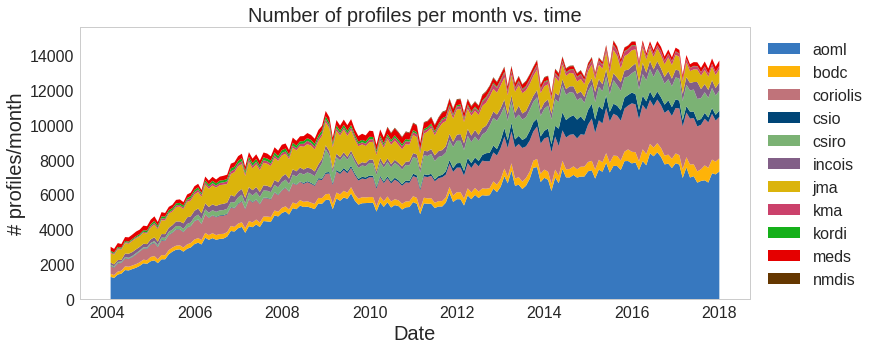

In [109]:
#sns.set_palette("husl")
fig = make_stack_plot(dacTimeSeriesDf, figsize=(12,5))
axes = plt.axes()
axes.legend(bbox_to_anchor=(1.19, 1.00), fontsize=16)

Here we can see which dacs are producing results over time. The next plot shows which transmission system the profiles are using. I lumped Iridium and GPS into one field. They are essentially equivalent.

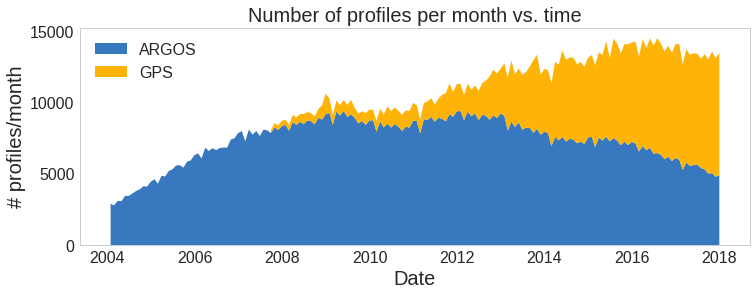

In [110]:
psdf=psTimeSeriesDf.copy()
psdf['GPS'] = psTimeSeriesDf['GPS'] + psTimeSeriesDf['IRIDIUM']
psdf.drop('GTS', axis = 1, inplace=True)
psdf.drop('IRIDIUM', axis = 1, inplace=True)
fig = make_stack_plot(psdf, figsize=(12,4))

The method below is used to get color scales from the cmap library, into a matplotlib scale.

In [111]:
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale
thermal_scl = matplotlib_to_plotly(cmocean.cm.thermal, 9)
haline_scl = matplotlib_to_plotly(cmocean.cm.haline, 9)

Argovis uses plotly, which is also available in python. Below the selection data from section 4 are plotted.

In [ ]:
def makeScatterTrace(df, colorValue, scl, units):
    trace = go.Scatter(
            x = df['profile_id'],
            y = df['pres'],
            text = df['temp'],
            mode = 'markers',
            marker = dict(
                size = 8,
                opacity = 0.8,
                autocolorscale = False,
                symbol = 'dot',
                line = dict(
                    width=0,
                    color='rgba(102, 102, 102)'),
                colorscale = scl,
                cmin = df['temp'].min(),
                color = df['temp'].round(1),
                cmax = df['temp'].max(),
                colorbar=dict(
                    title=units)
                )
        )
    return trace

def makeLayout(xlabel, ylabel, chartTitle):
    layout = dict(
            autosize=False,
            width=600,
            height=500,
            hovermode=True,
            title = chartTitle,
            titlefont=dict(
                size=16,
                ),
            colorbar = True,  
            xaxis=dict(
                title=xlabel,
                titlefont=dict(
                    size=16
                    ),
                    tickfont=dict(
                        size = 12
                    ),
                showticklabels=False,
                showgrid=False,
                zeroline=False,
                showline=False,
                ),
            yaxis=dict(
                title=ylabel,
                autorange='reversed',
                titlefont=dict(
                    size=16
                    ),
                tickfont=dict(
                    size = 12
                    ),
                showticklabels=True,
                showgrid=False,
                zeroline=False,
                showline=False,
                ),
            )
    return layout

temp_trace = makeScatterTrace(selectionDf, 'temp', thermal_scl, 'Celcius')
temp_layout = makeLayout('profile_id', 'Pressure [dbar]', 'Temperature profiles of selection')
fig1 = dict( data=[temp_trace], layout=temp_layout)
plot1 = iplot(fig1, validate=False)

The plot below was made with the code in the cell above.

In [28]:
%%html
<iframe width="600" height="500" frameborder="20" scrolling="no" src="//plot.ly/~tylertucker202/34.embed"></iframe>

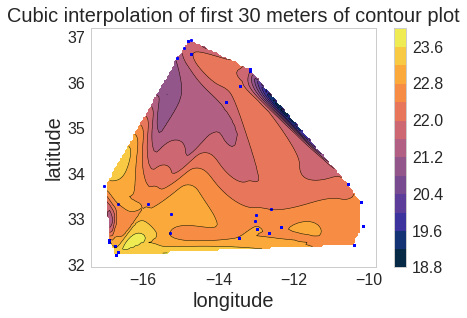

In [113]:
def contourPlot(df):
    fig = plt.figure()
    axes = plt.axes()
    xi = np.linspace(df['lon'].min(),df['lon'].max(),100)
    yi = np.linspace(df['lat'].min(),df['lat'].max(),100)
    
    x = df['lon'].values
    y = df['lat'].values
    z = df['temp'].values
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
    CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
    CS = plt.contourf(xi,yi,zi,15,cmap=cmocean.cm.thermal)
    axes.scatter(x,y,marker='o',c='b',s=5)
    axes.set_title('Cubic interpolation of first 30 meters of contour plot')

    axes.set_ylabel('latitude')
    axes.set_xlabel('longitude')
    cbar = fig.colorbar(CS, cmap = cmocean.cm.thermal)
    return fig

fig1 = contourPlot(selectionDf)

<a name="section_five"/> </a>
# 5. Time series

Stacking selection query averages 
Suppose that we average the temperature o selection query of Gibralter single value, and we give this value a time index. Repeating this process with an array of date ranges, we can create a time series. Just a disclaimer, this selection should be spatially averaged, but is left out; this is only a demonstration. 

In [8]:
def get_platform_measurements(profiles):
    '''
    Retrieves all measurements included in a list of platforms.
    '''
    stationParam = []
    for profile in profiles:
        stationParam.append(profile['station_parameters'])
    flatList = [item for sublist in stationParam for item in sublist]
    if isinstance(flatList[0], list):
        flatList = [item for sublist in flatList for item in sublist]
    uniqueList = list(set(flatList))
    uniqueList = [s for s in uniqueList if s != ''] # ignore blank station params.
                
    measurement_keys = [x.lower() for x in uniqueList]   
    return measurement_keys

def get_dates_set(period=30):
    n_rows = int(np.floor(365/period))
    datesSet = []
    for year in range(2004, 2018):
        yearSet = np.array_split(pd.date_range(str(year)+'-01-01', str(year)+'-12-31'), n_rows)
        datesSet = datesSet + yearSet
    keepEnds = lambda x: [x[0].strftime(format='%Y-%m-%d'), x[-1].strftime(format='%Y-%m-%d')]
    datesSet = list(map(keepEnds, datesSet))
    return datesSet

def get_ocean_time_series(seriesStartDate, seriesEndDate, shape, presRange='[0, 30]'):
    """Queries argovis database over long time scales but over one shape.
    shape should have a radius of no more than a few degrees.
    Pressure range should about 10-50 dbar.
    """
    
    selectionProfiles = get_selection_profiles(seriesStartDate, seriesEndDate, shape, presRange)
    if len(selectionProfiles) == 0:
        return
    meas_keys = get_platform_measurements(selectionProfiles)
    meas_keys = [s for s in meas_keys if s != ''] # ignore profiles that dont report anything
    print('Selection measurements: {}'.format(meas_keys))
    df = parse_into_df(selectionProfiles)
    
    #provide a time index for date ranges
    datesSet = get_dates_set(31)
    dateFormat = '%Y-%m-%dT%H:%M:%S.%fZ'
    df['date'] =  pd.to_datetime(df['date'], format=dateFormat)
    for idx, dates in enumerate(datesSet):
        startDate = datetime.strptime(dates[0], '%Y-%m-%d')
        endDate = datetime.strptime(dates[1], '%Y-%m-%d')
        try:
            if df[ (df['date'] < endDate) & (df['date'] > startDate)].shape[0] > 0: # sometimes there aren't any profiles at certain depth intervals
                df.loc[ (df['date'] <= endDate) & (df['date'] > startDate), 'tIndex'] = idx
                df.loc[ (df['date'] <= endDate) & (df['date'] > startDate), 'startDate'] = startDate
                df.loc[ (df['date'] <= endDate) & (df['date'] > startDate), 'endDate'] = endDate
        except ValueError:
            pdb.set_trace()
            df[ (df['date'] < startDate) & (df['date'] > endDate)].shape[0]

    df = df[np.isfinite(df['tIndex'])]
    #df.dropna(axis=1, how='any', inplace=True)
    #group and aggregate over tIndex
    tsDf = pd.DataFrame()
    grouped = df.groupby('tIndex')

    for tdx, group in grouped:
        nMeas = group.shape[0]
        if nMeas == 0:
            continue
        try:
            aggMean = group[meas_keys][group[meas_keys] != -999].mean()
            aggStd = group[meas_keys][group[meas_keys] != -999].std()
        except KeyError:
            pdb.set_trace()
            grouped.columns
        startDate = group['startDate'].values[0]
        endDate = group['endDate'].values[0]
        for key in meas_keys:
            tsDf.at[tdx, key+'Mean'] = aggMean[key]
            tsDf.at[tdx, key+'Std'] = aggStd[key]
        tsDf.at[tdx, 'startDate'] = startDate
        tsDf.at[tdx, 'endDate'] = endDate
        tsDf.at[tdx, 'nProf'] = nMeas
    return tsDf

In [120]:
tsDf = get_ocean_time_series('2004-01-01', '2017-12-31', shape, presRange='[0, 30]')
tsDf.to_csv(os.path.join(docDir,'gilbralter.csv'))

Selection measurements: ['doxy', 'psal', 'temp', 'cndc', 'pres']


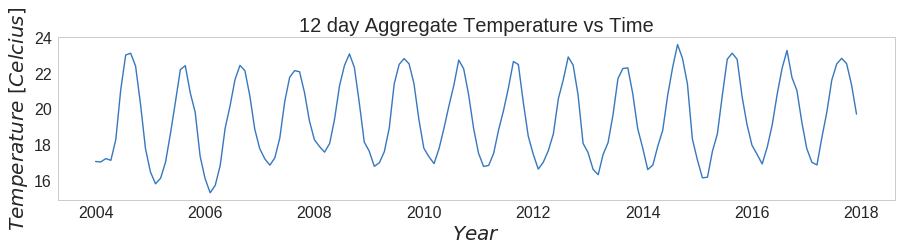

In [121]:
tsDf = pd.read_csv(os.path.join(docDir,'gilbralter.csv'))
#tsDf = tsDf[['tempMean', 'cndcMean' 'psalMean', 'tempStd', 'psalStd', 'startDate', 'endDate', 'nProf']]
tsDf['startDate'] = pd.to_datetime(tsDf['startDate'])
tsDf['endDate'] = pd.to_datetime(tsDf['endDate'])
fig = plt.figure(999, figsize=(15,3))
axes = plt.axes()
temp = tsDf['tempMean'].values
time = tsDf['startDate'].values
axes.plot(time, temp)
axes.set_title(r'12 day Aggregate Temperature vs Time')
axes.set_ylabel(r'$Temperature\ [Celcius]$')
axes.set_xlabel(r'$Year$')

<a name="section_six"/> </a>
# 6. Query by grid 

Where the get_ocean_time_series function goes through long time ranges, the get_ocean_df_from_csv queries a large grid over a short period of time.  

In [9]:
def get_ocean_df(oceanFileName, subGrid=None):
    """
    Retrieves gridded data used for get_ocean_df_from_csv and filters out to subGrid if exists.
    """
    oceanDf = pd.read_csv(oceanFileName)
    oceanDf.set_index('idx', inplace=True)
    if type(subGrid) != type(None):
        oceanDf = oceanDf[(oceanDf.lat >= subGrid['latMin']) &
                          (oceanDf.lat <= subGrid['latMax']) &
                          (oceanDf.lon >= subGrid['lonMin']) &
                          (oceanDf.lon <= subGrid['lonMax'])]
        print('oceanDF searching for {} areas'.format(oceanDf.shape[0]))
    return oceanDf

def get_pres_intervals(minPres, maxPres, dPres):
    """
    Creates an array of pressure intervalues used to break the grid up into vertical elements
    """
    presBin = np.arange(minPres, maxPres+dPres, dPres)
    presIntervals = []
    for idx, pres in enumerate(presBin[0:-1]):
        interval = presBin[idx:idx+2]
        presIntervals.append([idx, interval])
    return presIntervals


def get_ocean_df_from_csv(oceanDfCoords, startDate, endDate, presRange, presIntervals, nElem):
    """queries argovis database over large gridded space and small time scales.
    Ocean file name contains coordinates.
    Output is saves as a csv.
    Start date and End date are usually about 10-30 days
    """
    for row in oceanDfCoords.itertuples():
        shapeStr = '['+str(row.shape)+']'
        selectionProfiles = get_selection_profiles(startDate, endDate, shapeStr, presRange)
        if len(selectionProfiles) == 0:
            continue
        df = parse_into_df(selectionProfiles)
        if df.shape[0] == 0: #  move on if selection profiles don't turn up anything.
            continue
        # aggregate into pressure intervals            
        for ldx, pres in presIntervals:
            try:
                if df[ (df['pres'] < pres[1]) & (df['pres'] > pres[0])].shape[0] > 0: # sometimes there aren't any profiles at certain depth intervals
                    df.loc[ (df['pres'] <= pres[1]) & (df['pres'] > pres[0]), 'ldx'] = ldx
                    df.loc[ (df['pres'] <= pres[1]) & (df['pres'] > pres[0]), 'presMin'] = pres[0]
                    df.loc[ (df['pres'] <= pres[1]) & (df['pres'] > pres[0]), 'presMax'] = pres[1]
            except ValueError:
                pdb.set_trace()
                df[ (df['pres'] < pres[1]) & (df['pres'] > pres[0])].shape[0]
        if not 'ldx' in df.columns:  # sometimes there are no measurements in the given pressure intervals
            continue
        try:
            grouped = df.groupby('ldx')
        except KeyError:
            pdb.set_trace()
            df.shape
        for ldx, group in grouped:
            nMeas = group.shape[0]
            if nMeas == 0:
                continue
            try:
                if not 'psal' in group.columns:
                    group['psal'] = np.nan
                if not 'temp' in group.columns:
                    group['temp'] = np.nan
                aggMean = group[['temp', 'psal']].mean()
            except:
                pdb.set_trace()
                asdf = 'aasdf'

            idx = row.Index + ldx * nElem
            oceanDf.set_value(idx, 'aggTemp', aggMean.temp)
            oceanDf.set_value(idx, 'aggPsal', aggMean.psal)
            oceanDf.set_value(idx, 'nProf', nMeas)
    oceanDf.dropna(axis=0, how='any', thresh=2, subset=['aggTemp', 'aggPsal', 'nProf'], inplace=True)
    return oceanDf

In [123]:
oceanFileName = 'oceanCoordsAtOneDeg.csv'
nElem = 180*360
presRange = '[0, 30]' #  used to query database
startDate='2017-10-15'
endDate='2017-10-30'
minPres = 0 #  breaks up query into levels
maxPres = 30
dPres = 30
oceanDfCoords = get_ocean_df(oceanFileName)
presIntervals = get_pres_intervals(minPres, maxPres, dPres)

oceanDf is generated from one degree grids with land masks, provided by JPL. THe citation is below. Any grid point with 50 percent land or higher is omitted from oceanDf. Half and quarter degree grids are available.

Jet Propulsion Laboratory. 2013. ISLSCP II Land and Water Masks with Ancillary Data. Data set. Available on-line [http://daac.ornl.gov/] from Oak Ridge National Laboratory Distributed Active Archive Center, Oak Ridge, Tennessee, USA. http://dx.doi.org/10.3334/ORNLDAAC/1200

In [ ]:
oceanDf = get_ocean_df_from_csv(oceanDfCoords, startDate, endDate, presRange, presIntervals, nElem)
oceanDf.to_csv(os.path.join(docDir,'shallow_one_deg_grid.csv'))

In [125]:
oceanDf = pd.read_csv(os.path.join(docDir,'shallow_one_deg_grid.csv'))
oceanDf.index=oceanDf.idx

In [126]:
#used for gridding purposes
worldGrid = pd.read_csv('worldGridAtOneDeg.csv')
worldGrid.index=worldGrid.idx
oceanGrid = pd.concat([oceanDf[['nProf', 'aggTemp', 'aggPsal']], worldGrid[['lat', 'lon']]], axis=1, join='outer')
oceanGrid.fillna(0, inplace=True)

<a name="section_seven"/> </a>
# 7. Plot on map projections

There are a few options in python when plotting on map projections. I am familiar with [Cartopy](http://scitools.org.uk/cartopy/) and [Basemap](https://www.google.com) libraries.

## Cartopy

Cartopy is the most up to date library, and will eventually replace Basemap. The version used in this libary is 0.15. It still has a ways to go, but I included it anyways.

In [ ]:
def plot_pmesh(df):
    fig = plt.figure(figsize=(8,12))
    df.sort_values(by=['lon', 'lat'], ascending=[True, False], inplace=True)
    x = df['lon'].values.reshape(180,360)
    y = df['lat'].values.reshape(180,360)
    z = df['nProf'].values.reshape(180,360)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(zorder=1)
    plt.pcolormesh(x, y, z,vmax=40, cmap=cmocean.cm.dense, transform=ccrs.PlateCarree(),zorder=0)
    return fig

df = oceanGrid
pmeshfig = plot_pmesh(df)
plt.show()

## Basemap

I am more familiar with Basemap, but its depreciated. Note that in python3 you will have to troubleshoot. Dispite its flaws, you can create some fantastic maps. Below is a scatter plot of our monthly queried data.

In [10]:
delta = 1/4
360 * 180 / (1/4)

259200.0

In [54]:
def create_idx(lat, lon, layer, delta):
    row = (180 - lat) / delta
    col = (360 - lon) / delta
    idx = (1 + row)*col*layer
    return idx

def agg_gridded(df, measKeys):
    #group and aggregate over latbin and lonbin
    aggDf = pd.DataFrame()
    grouped = df.groupby(level=['latbin', 'lonbin'])
    for tdx, group in grouped:
        nMeas = group.shape[0]
        gridIdx = group['idx'].values[0]
        latbin, lonbin = tdx
        if nMeas == 0:
            continue
        try:
            aggMean = group[group != -999].mean()
            aggStd = group[group != -999].std()
        except KeyError:
            pdb.set_trace()
            grouped.columns
        for key in measKeys:
            if not key in group.columns:
                continue
            aggDf.at[gridIdx, key+'Mean'] = aggMean[key]
            aggDf.at[gridIdx, key+'Std'] = aggStd[key]
        aggDf.at[gridIdx, 'nProf'] = nMeas
        aggDf.at[gridIdx, 'latbin'] = latbin
        aggDf.at[gridIdx, 'lonbin'] = lonbin
    return aggDf

def bin_layer_df(df, delta, layer):
    to_bin = lambda x: np.floor(x / delta) * delta
    df['latbin'] = df.lat.map(to_bin)
    df['lonbin'] = df.lon.map(to_bin)
    df['idx'] = create_idx(df['latbin'], df['lonbin'], layer, delta).astype('int')
    df.set_index(['latbin', 'lonbin'], inplace=True)
    return df

def get_ocean_slice(startDate, endDate, presRange='[0,30]'):
    baseURL = 'http://www.argovis.com/gridding/presSlice/'
    startDateQuery = '?startDate=' + startDate
    endDateQuery = '&endDate=' + endDate
    presRangeQuery = '&presRange=' + presRange
    url = baseURL + startDateQuery + endDateQuery + presRangeQuery
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    oceanSliceProfiles = resp.json()
    return oceanSliceProfiles

startDate='2018-02-28'
endDate='2018-02-29'
oceanSliceProfiles = get_ocean_slice(startDate, endDate, presRange='[0,30]')
measKeys = get_platform_measurements(oceanSliceProfiles)
measKeys = [s for s in measKeys if s != ''] # ignore profiles that dont report anything
oceanSliceDf = parse_into_df(oceanSliceProfiles)

In [55]:
oceanSliceDf.head()

chla  cycle_number                      date  doxy        lat        lon  \
0   NaN         265.0  2018-02-28T23:59:00.000Z   NaN  41.152055  40.491613   
1   NaN         265.0  2018-02-28T23:59:00.000Z   NaN  41.152055  40.491613   
2   NaN         265.0  2018-02-28T23:59:00.000Z   NaN  41.152055  40.491613   
3   NaN         265.0  2018-02-28T23:59:00.000Z   NaN  41.152055  40.491613   
4   NaN         265.0  2018-02-28T23:59:00.000Z   NaN  41.152055  40.491613   

   nitrate       pres   profile_id       psal    temp  
0      NaN   7.700000  6901831_265  18.289000  10.703  
1      NaN  12.500000  6901831_265  18.288000  10.713  
2      NaN  17.700001  6901831_265  18.290001  10.691  
3      NaN  22.799999  6901831_265  18.298000  10.570  
4      NaN  28.200001  6901831_265  18.312000  10.495

In [56]:
oceanSliceDf = bin_layer_df(oceanSliceDf, delta=1/4, layer=1)
oceanSliceDf = agg_gridded(oceanSliceDf, measKeys)
oceanSliceDf.head()

doxyMean  doxyStd  tempMean   tempStd   psalMean   psalStd  \
2123548       NaN      NaN -1.202467  0.097845  33.303800  0.186600   
2188080       NaN      NaN -0.972692  0.000947  34.168999  0.000000   
2132110       NaN      NaN -1.605538  0.065271  33.278846  0.395374   
1875060       NaN      NaN -0.084214  0.000802  33.336571  0.002980   
742500        NaN      NaN -0.250150  0.000988  33.946401  0.000291   

          presMean   presStd  chlaMean  chlaStd  nProf  latbin  lonbin  
2123548  16.386667  8.793412       NaN      NaN   15.0  -74.25 -161.50  
2188080  16.613077  7.756949       NaN      NaN   13.0  -73.00 -180.00  
2132110  17.007692  7.746769       NaN      NaN   13.0  -72.25 -167.75  
1875060  15.712858  8.275959       NaN      NaN   14.0  -67.25 -113.50  
742500   12.266000  8.314495       NaN      NaN   20.0  -67.25  172.50

In [47]:
df=assign_idx(oceanSliceDf, 1, 1/4)
df.head()

doxyMean  doxyStd  tempMean   tempStd   psalMean   psalStd  \
2123548.0       NaN      NaN -1.202467  0.097845  33.303800  0.186600   
2188080.0       NaN      NaN -0.972692  0.000947  34.168999  0.000000   
2132110.0       NaN      NaN -1.605538  0.065271  33.278846  0.395374   
1875060.0       NaN      NaN -0.084214  0.000802  33.336571  0.002980   
742500.0        NaN      NaN -0.250150  0.000988  33.946401  0.000291   

            presMean   presStd  chlaMean  chlaStd  nProf  latbin  lonbin  \
2123548.0  16.386667  8.793412       NaN      NaN   15.0  -74.25 -161.50   
2188080.0  16.613077  7.756949       NaN      NaN   13.0  -73.00 -180.00   
2132110.0  17.007692  7.746769       NaN      NaN   13.0  -72.25 -167.75   
1875060.0  15.712858  8.275959       NaN      NaN   14.0  -67.25 -113.50   
742500.0   12.266000  8.314495       NaN      NaN   20.0  -67.25  172.50   

              row     col  layer      idx  
2123548.0  1017.0  2086.0      1  2123548  
2188080.0  1012.0  2160.0      1  2188080  
2132110.0  1009.0  2111.0      1  2132110  
1875060.0   989.0  1894.0      1  1875060  
742500.0    989.0   750.0      1   742500

In [29]:
def create_idx(lat, lon, layer, delta):
    row = (180 - lat) / delta
    col = (360 - lon) / delta
    idx = (1 + row)*col*layer
    return idx

idx = create_idx(oceanSliceDf['latbin'], oceanSliceDf['lonbin'], 1, 1/4)

In [31]:
idx.head()

2123548    2123548.0
2188080    2188080.0
2132110    2132110.0
1875060    1875060.0
742500      742500.0
dtype: float64

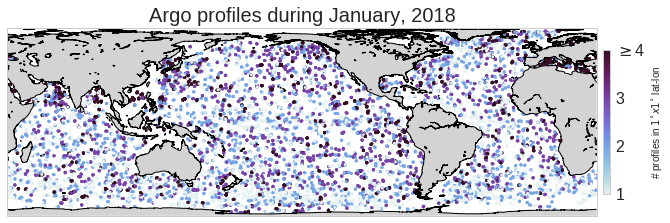

In [18]:
monthlyProfilePos = get_monthly_profile_pos(1, 2018)
monthlyDf = parse_pos_into_df(monthlyProfilePos)
binnedDf = bin_pos_df(monthlyDf, 1)
fig = plt.figure(figsize=(9,6))
ax = fig.add_axes([0.001,0.001,0.93,1])
#m = Basemap(projection='cea',llcrnrlat=-90,urcrnrlat=90,\
#            llcrnrlon=-180,urcrnrlon=180,resolution='l')
m = Basemap(projection='cea',lon_0=-145, lat_0 = 50,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='lightgrey')
# draw parallels and meridians.
df = binnedDf

nProf = df.nProf.values
x, y = m(df.lon.values, df.lat.values)
m.scatter(x, y, c=nProf, vmax=4, cmap=cmocean.cm.dense, s=8)
cb = plt.colorbar(location='right', format='%d', fraction=0.012, pad=0.01)
plt.title("Argo profiles during January, 2018".format(startDate, endDate))
cb.set_label('# profiles in $1^{\circ}x1^{\circ}$ lat-lon', size=10)
cb.set_ticks([1, 2,3,4])
cb.set_ticklabels(['1',  '2',  '3',  '$\geq$4'])

For interpolating, I personally like using matplotlib's pcolormesh.

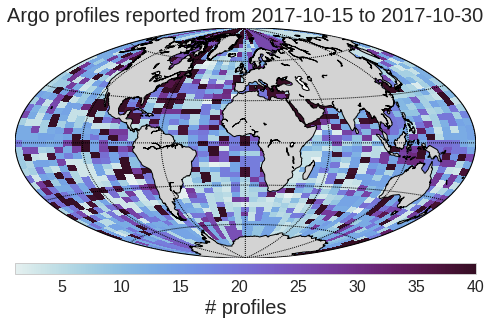

In [130]:
def plot_pcolor_mesh(df, granularity, title = '', vmax=40):
    fig = plt.figure(figsize=(8,12))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    m = Basemap(projection='hammer',lon_0=0, lat_0 = 50, resolution='c')
    m.drawcoastlines()
    m.fillcontinents(color='lightgrey')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,120.,30.))
    m.drawmeridians(np.arange(0.,420.,60.))
    df.sort_values(by=['lon', 'lat'], ascending=[True, False], inplace=True)
    x = df['lon'].values
    y = df['lat'].values
    z = df['nProf'].values
    xx, yy = np.mgrid[-180: 180: granularity, -90: 90: granularity]
    zi = griddata((x, y), z, (xx, yy), method='nearest')
    
    xx, yy = m(xx, yy)
    m.pcolormesh(xx, yy, zi, vmax=vmax, latlon=False, cmap=cmocean.cm.dense)
    plt.title(title)
    cb = m.colorbar(location='bottom', format='%d', label='# profiles')
    return fig

title = "Argo profiles reported from {} to {}".format(startDate, endDate)
coarse = plot_pcolor_mesh(oceanDf, 50j, title)

You can adjust the granularity of pcolormesh as well.

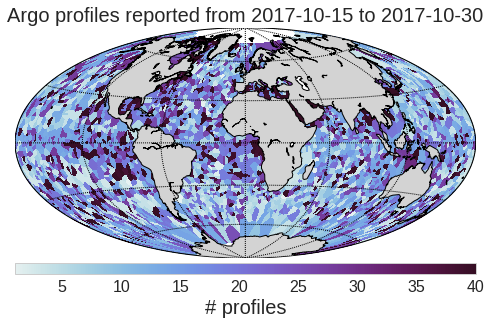

In [131]:
fine = plot_pcolor_mesh(oceanDf, 3000j, title)

Lastly, we can upload the data gathered from [section 3.2](#section_three_two)

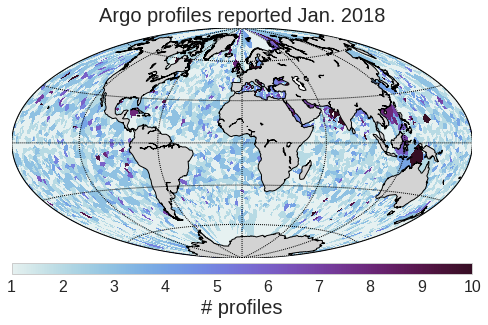

In [132]:
binned_title = 'Argo profiles reported Jan. 2018'
binned = plot_pcolor_mesh(binnedDf, 1000j, binned_title, 10)

# Conclusion

The three main functions described in sections 1, 2, and 3 can be written in a number or languages, such as R or Matlab. This project is still new, and will continue to evolve and improve. Feel free to email ttucker@sdsu.edu for questions/requests. Thanks!